### ZeroAccess

An interesting data set
* Where ZeroAccess occurs? Any patterns?
* What kind of users are easily to be infected? Does education or income affect infection rate?
* Does UFO cause ZeroAccess infection?



In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
z_df = pd.read_csv("https://drive.google.com/uc?id=13iE3A-OO_oWZrEvDmpN_nA6yPfLpCiZv") # zeroaccess.csv
s_df = pd.read_csv("https://drive.google.com/uc?id=13nE04n2MwRAMFSPxS96dYMe1RYgZujxS") # state-internets.csv
c_df = pd.read_csv("https://drive.google.com/uc?id=13qH1zWX4FQGNo43m_7ufSsDUbYUxa81O") # county-data.csv

In [54]:
print(z_df.shape, s_df.shape, c_df.shape)

(808446, 2) (49, 3) (3072, 6)


In [55]:
z_df.head()

,lat,long
0,-10.0000,-55.0000
1,38.0888,-78.5592
2,38.9990,-84.6266
3,48.6210,7.4944
4,43.2342,-86.2484


In [56]:
s_df.head()

,state,population,internet
0,Alabama,4758191,3092273
1,Arizona,6665093,5230474
2,Arkansas,2919815,1949869
3,California,37350092,29758896
4,Colorado,5077553,4058749


In [57]:
c_df.head()

,subregion,region,pop,income,ipaddr,ufo2010
0,abbeville,south carolina,25101,34670,30330,2
1,acadia,louisiana,61912,37970,38203,6
2,accomack,virginia,33341,41595,41338,2
3,ada,idaho,409061,55304,1035427,59
4,adair,iowa,7481,47623,3762,0


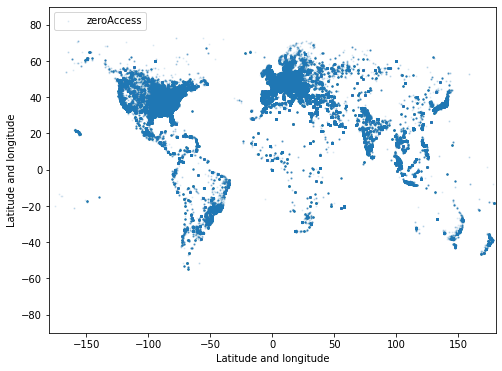

In [58]:
# plot zeroAccess infection instances on a earth map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.scatter(z_df.long, z_df.lat, alpha = 0.1, s = 1, label = "zeroAccess")
ax.set_xlim((-180, 180))
ax.set_ylim((-90, 90))

plt.xlabel("Latitude and longitude")
plt.ylabel("Latitude and longitude")
plt.legend(loc='upper left')

plt.show()

In [59]:
# https://python-visualization.github.io/folium/quickstart.html

import folium
from folium.plugins import HeatMap
mapa = folium.Map(location=(10, 10), zoom_start=1.5, tiles="Stamen Toner", height="50%", width="50%")
loc_li = list(zip(list(z_df.lat), (z_df.long)))[:10000] # <-- change data size
HeatMap(loc_li, radius=15).add_to(mapa) # <-----------------------change radius
mapa

### Reverse Geocoding



In [60]:
!pip install reverse_geocoder

In [61]:
import reverse_geocoder

# {'lat': '51.51116', 'lon': '-0.18426', 'name': 'Bayswater', 
#  'admin1': 'England', 'admin2': 'Greater London', 'cc': 'GB'}

# quick implementation
def rgr(s):
  cord_li = [(s[0], s[1])]
  result_dict_li = reverse_geocoder.search(cord_li)
  ret_ser = pd.Series(dict(result_dict_li[0]))
  return ret_ser.drop(labels=['lat', 'lon'])

# batch implementation
def rgr_batch(lat_long_df):
  cord_li = []
  for ind in lat_long_df.index:
    cord_li.append((lat_long_df['lat'][ind], lat_long_df['long'][ind]))
  result_dict_li = reverse_geocoder.search(cord_li)
  return pd.DataFrame(result_dict_li).drop(["lat", "lon"], axis = 1)

In [62]:
# quick implementation
'''
sample_df = z_df.head(50) # <------ only use some data, because it takes time
country_df = sample_df.apply(lambda s: rgr(s), axis = 1)
df = sample_df.join(country_df)
df
'''

'\nsample_df = z_df.head(50) # <------ only use some data, because it takes time\ncountry_df = sample_df.apply(lambda s: rgr(s), axis = 1)\ndf = sample_df.join(country_df)\ndf\n'

In [63]:
# batch implementation
sample_df = z_df.head(50000) # <------ only use some data, because it takes time
country_df = rgr_batch(sample_df)
df = sample_df.join(country_df).rename(columns={'name':'City', 'admin1': 'State', 'admin2':'County', 'cc':"country_code", })
df

,lat,long,City,State,County,country_code
0,-10.0000,-55.0000,Alta Floresta,Mato Grosso,Alta Floresta,BR
1,38.0888,-78.5592,Charlottesville,Virginia,City of Charlottesville,US
2,38.9990,-84.6266,Florence,Kentucky,Boone County,US
3,48.6210,7.4944,Marlenheim,Alsace,Departement du Bas-Rhin,FR
4,43.2342,-86.2484,Muskegon,Michigan,Muskegon County,US
...,...,...,...,...,...,...
49995,53.1271,18.0200,Bydgoszcz,Kujawsko-Pomorskie,Bydgoszcz,PL
49996,42.6757,-82.7773,New Baltimore,Michigan,Macomb County,US
49997,43.5417,21.7078,Aleksinac,Central Serbia,Nisavski Okrug,RS
49998,28.2397,-82.7388,New Port Richey,Florida,Pasco County,US


### Question #1:
Plot a figure to show # of attack in each country

In [64]:
num_df = df.groupby('country_code')['country_code'].count().reset_index(name = '# of attack')
num_df

,country_code,# of attack
0,AE,165
1,AF,9
2,AI,1
3,AL,19
4,AM,20
...,...,...
178,XK,5
179,YE,7
180,ZA,201
181,ZM,13


### Question #2:

Plot a figure to show % of attack in each country
Ignore countries that are < 1%

In [65]:
num_df['% of attack'] = num_df['# of attack'] / 50000
pc_df = num_df.loc[num_df['% of attack'] >= 0.01]
pc_df.sort_values(by = '% of attack', ascending = False, inplace = True)
pc_df.drop(['# of attack'], axis = 1, inplace = True)
pc_df.index = range(13)
pc_df

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,country_code,% of attack
0,US,0.47974
1,CA,0.05932
2,GB,0.05128
3,JP,0.03008
4,AU,0.03002
5,IT,0.02964
6,DE,0.02824
7,FR,0.02622
8,BR,0.01928
9,IN,0.01496


([<matplotlib.axis.XTick at 0x7f4b01ecd450>,
 [Text(0, 0, 'US'),
  Text(0, 0, 'CA'),
  Text(0, 0, 'GB'),
  Text(0, 0, 'JP'),
  Text(0, 0, 'AU'),
  Text(0, 0, 'IT'),
  Text(0, 0, 'DE'),
  Text(0, 0, 'FR'),
  Text(0, 0, 'BR'),
  Text(0, 0, 'IN'),
  Text(0, 0, 'PL'),
  Text(0, 0, 'PK'),
  Text(0, 0, 'TR')])

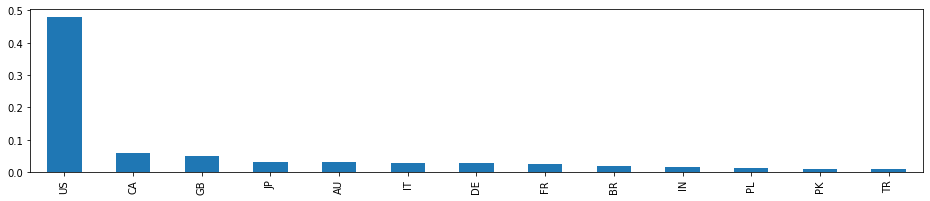

In [66]:
fig = plt.figure(figsize=(16,3))
countries = pc_df['country_code']
pc_df['% of attack'].plot(kind = 'bar')
plt.xticks(range(0, 13, 1), labels = countries)

### Question #3:

Only show US data and map.
Show US state data.

Which state/ciry has severe attack? Why?

Hint: recall a network tool named 'whois' ...


In [67]:
us_df = df[df.country_code == 'US']
us_df

,lat,long,City,State,County,country_code
1,38.0888,-78.5592,Charlottesville,Virginia,City of Charlottesville,US
2,38.9990,-84.6266,Florence,Kentucky,Boone County,US
4,43.2342,-86.2484,Muskegon,Michigan,Muskegon County,US
6,44.8012,-68.7778,Bangor,Maine,Penobscot County,US
8,36.0580,-88.8253,Bradford,Tennessee,Gibson County,US
...,...,...,...,...,...,...
49992,40.6374,-79.7264,Brackenridge,Pennsylvania,Allegheny County,US
49994,38.4380,-122.6753,Santa Rosa,California,Sonoma County,US
49996,42.6757,-82.7773,New Baltimore,Michigan,Macomb County,US
49998,28.2397,-82.7388,New Port Richey,Florida,Pasco County,US


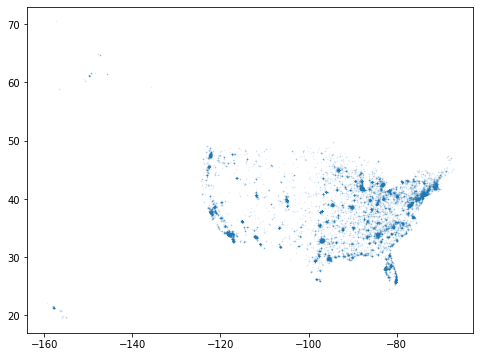

In [68]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.scatter(us_df.long, us_df.lat, alpha = 0.1, s = 0.3)

In [69]:
state_df = us_df.groupby('State')['State'].count().reset_index(name = 'attack')
state_df.sort_values(by = 'attack', ascending = False, inplace = True)
state_df.index = range(51)
state_df

,State,attack
0,California,2293
1,Texas,2003
2,Florida,1425
3,Kansas,1371
4,New York,1315
5,Pennsylvania,970
6,Illinois,948
7,Ohio,914
8,Georgia,841
9,North Carolina,759


In [70]:
city_df = us_df.groupby(['State', 'City'])['City'].count().reset_index(name = 'attack')
city_df.sort_values(by = 'attack', ascending = False, inplace = True)
city_df.index = range(6660)
city_df

,State,City,attack
0,Kansas,Peabody,1152
1,Texas,Houston,238
2,California,Los Angeles,179
3,Illinois,Chicago,144
4,Arizona,Phoenix,142
...,...,...,...
6655,California,Dixon,1
6656,Louisiana,Sulphur,1
6657,Louisiana,Springhill,1
6658,North Carolina,Williamston,1


### Question #4:

Is there anything wrong with these states? <br>
There are outliers which have severe attack.

In [71]:
sum = state_df['attack'].sum()

state_df['att_pc'] = state_df['attack'] / sum
state_df

,State,attack,att_pc
0,California,2293,0.095593
1,Texas,2003,0.083504
2,Florida,1425,0.059407
3,Kansas,1371,0.057156
4,New York,1315,0.054821
5,Pennsylvania,970,0.040439
6,Illinois,948,0.039521
7,Ohio,914,0.038104
8,Georgia,841,0.035061
9,North Carolina,759,0.031642


In [72]:
state_df.describe()

,attack,att_pc
count,51.000000,51.000000
mean,470.333333,0.019608
std,490.681635,0.020456
min,31.000000,0.001292
25%,123.000000,0.005128
50%,373.000000,0.015550
75%,514.500000,0.021449
max,2293.000000,0.095593


In [73]:
IQR = state_df.describe().loc['75%', 'attack'] - state_df.describe().loc['25%', 'attack']

q1_lower = state_df.describe().loc['25%', 'attack'] - 1.5 * IQR
q3_higher = state_df.describe().loc['75%', 'attack'] + 1.5 * IQR

lower_df = state_df.loc[state_df['attack'] < q1_lower]
higher_df = state_df.loc[state_df['attack'] > q3_higher]

outliers_df = pd.concat([lower_df, higher_df], axis = 0)
outliers_df

,State,attack,att_pc
0,California,2293,0.095593
1,Texas,2003,0.083504
2,Florida,1425,0.059407
3,Kansas,1371,0.057156
4,New York,1315,0.054821


### Question #5:

Are the attack occurances in each state related to state population?

Try a bar chart!

In [74]:
pop_df = pd.merge(us_df, s_df.rename(columns = {'state':'State'}))
pop_df = pop_df.groupby(['State', 'population'])['population'].count().reset_index(name = 'attack')
pop_df.sort_values(by = 'attack', ascending = False, inplace = True)
pop_df.index = range(48)
pop_df['att_pc'] = pop_df['attack'] / pop_df['attack'].sum()
pop_df['pop_pc'] = pop_df['population'] / pop_df['population'].sum()
pop_df

,State,population,attack,att_pc,pop_pc
0,California,37350092,2293,0.096300,0.121419
1,Texas,25042738,2003,0.084121,0.081410
2,Florida,18732783,1425,0.059846,0.060897
3,Kansas,2848369,1371,0.057578,0.009260
4,New York,19746813,1315,0.055227,0.064194
5,Pennsylvania,12737230,970,0.040737,0.041407
6,Illinois,13046084,948,0.039814,0.042411
7,Ohio,11663946,914,0.038386,0.037918
8,Georgia,9932505,841,0.035320,0.032289
9,North Carolina,9479467,759,0.031876,0.030816


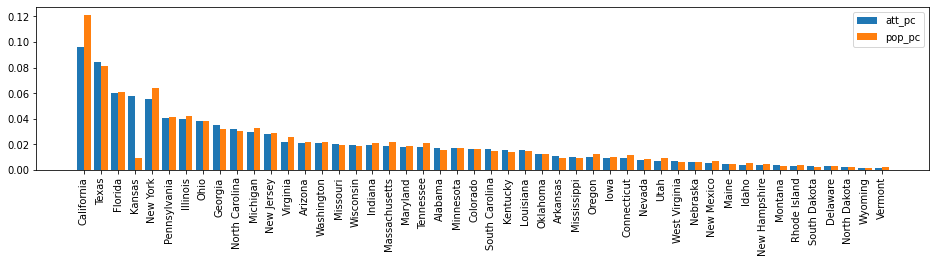

In [75]:
fig = plt.figure(figsize=(16,3))

state = pop_df.State.values
att = pop_df.att_pc.values
pop = pop_df.pop_pc.values
  
X = state
Y = att
Z = pop
  
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, Y, 0.4, label = 'att_pc')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'pop_pc')
  
plt.xticks(X_axis, X,rotation='vertical')

plt.legend()
plt.show()

### UFO?

Try to use county-data.csv data to predict the attack counts for each state by liner regression.

Which feature is the best?

In [76]:
pop = c_df.groupby('region')['pop'].agg('sum')
pop = pd.DataFrame(pop, columns = ['pop'])

income = c_df.groupby('region')['income'].agg('sum')
income = pd.DataFrame(income, columns = ['income'])

ipaddr = c_df.groupby('region')['ipaddr'].agg('sum')
ipaddr = pd.DataFrame(ipaddr, columns = ['ipaddr'])

ufo2010 = c_df.groupby('region')['ufo2010'].agg('sum')
ufo2010 = pd.DataFrame(ufo2010, columns = ['ufo2010'])

country_df = pd.concat([pop, income, ipaddr, ufo2010], axis = 1)

# build pop_df
us_df['State'] = us_df['State'].str.lower()
s_df['state'] = s_df['state'].str.lower()
pop_df = pd.merge(us_df, s_df.rename(columns = {'state':'State'}))
pop_df = pop_df.groupby('State')['State'].count()
pop_df = pd.DataFrame(pop_df, columns = ['State']).rename(columns = {'State':'attack'})

country_df = pd.concat([country_df, pop_df], axis = 1)

# country_df['att_pc'] = country_df['attack'] / country_df['attack'].sum()
# country_df['pop_pc'] = country_df['pop'] / country_df['pop'].sum()

country_df['pop'] = country_df['pop'].astype(np.float64)
country_df['income'] = country_df['income'].astype(np.float64)
country_df['ipaddr'] = country_df['ipaddr'].astype(np.float64)
country_df['ufo2010'] = country_df['ufo2010'].astype(np.float64)

country_df.loc['district of columbia', 'attack'] = 0

country_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,pop,income,ipaddr,ufo2010,attack
alabama,4822023.0,2522962.0,22542601.0,250.0,412.0
arizona,6532974.0,612727.0,62062174.0,1250.0,503.0
arkansas,2949131.0,2677866.0,4810526.0,265.0,262.0
california,38041430.0,3241756.0,156511903.0,3769.0,2293.0
colorado,5129284.0,3206281.0,22787577.0,513.0,394.0
connecticut,3590347.0,565060.0,40993589.0,280.0,226.0
delaware,917092.0,172156.0,19378182.0,74.0,68.0
district of columbia,632323.0,61835.0,10759507.0,1.0,0.0
florida,19317568.0,2990011.0,23716071.0,1465.0,1425.0
georgia,9919945.0,6433814.0,20947043.0,548.0,841.0


In [77]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(country_df, test_size = 0.2)

In [78]:
train

,pop,income,ipaddr,ufo2010,attack
wisconsin,5722058.0,3502385.0,9246404.0,421.0,472.0
delaware,917092.0,172156.0,19378182.0,74.0,68.0
alabama,4822023.0,2522962.0,22542601.0,250.0,412.0
connecticut,3590347.0,565060.0,40993589.0,280.0,226.0
idaho,1595728.0,1904783.0,2148449.0,161.0,99.0
mississippi,2984926.0,2812894.0,2050835.0,88.0,241.0
illinois,12875255.0,4926504.0,29586316.0,1027.0,948.0
texas,26059203.0,11307750.0,63230468.0,1706.0,2003.0
vermont,626011.0,718544.0,988910.0,42.0,31.0
oregon,3899353.0,1616532.0,8134133.0,717.0,235.0


In [79]:
test

,pop,income,ipaddr,ufo2010,attack
massachusetts,6646144.0,902542.0,41855676.0,441.0,453.0
missouri,6021988.0,4672209.0,18503112.0,489.0,480.0
pennsylvania,12763536.0,3212933.0,22715306.0,730.0,970.0
south carolina,4723723.0,1793990.0,5256663.0,336.0,386.0
west virginia,1855413.0,2033260.0,1389593.0,172.0,161.0
ohio,11544225.0,4125406.0,240752799.0,700.0,914.0
california,38041430.0,3241756.0,156511903.0,3769.0,2293.0
maine,1329192.0,718543.0,1541702.0,164.0,113.0
nebraska,1855525.0,4160090.0,3211714.0,199.0,144.0
new jersey,8864590.0,1511536.0,55597788.0,404.0,669.0


In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, wisconsin to nevada
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pop      39 non-null     float64
 1   income   39 non-null     float64
 2   ipaddr   39 non-null     float64
 3   ufo2010  39 non-null     float64
 4   attack   39 non-null     float64
dtypes: float64(5)
memory usage: 1.8+ KB


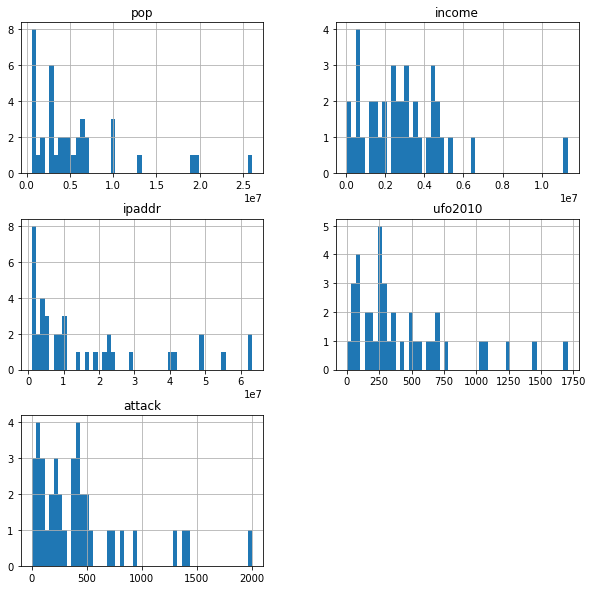

In [81]:
train.hist(bins=50, figsize=(10,10))
# print("could you make a comment to all the historgrams?")
plt.show()

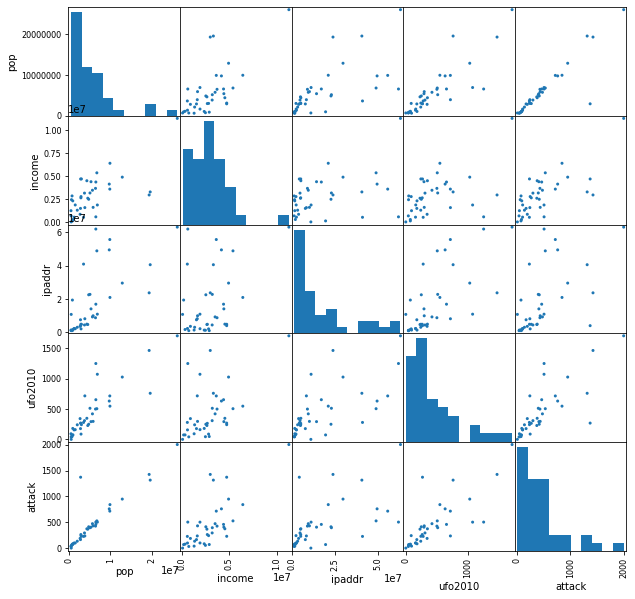

In [82]:
pd.plotting.scatter_matrix(train, alpha=1, figsize=(10,10), diagonal='hist')
plt.show()

In [83]:
corr_matrix = train.corr()
corr_matrix.style.background_gradient()

,pop,income,ipaddr,ufo2010,attack
pop,1.000000,0.673979,0.680382,0.858746,0.905775
income,0.673979,1.000000,0.410900,0.521524,0.729877
ipaddr,0.680382,0.410900,1.000000,0.684197,0.596903
ufo2010,0.858746,0.521524,0.684197,1.000000,0.782066
attack,0.905775,0.729877,0.596903,0.782066,1.000000


In [84]:
corr_matrix['attack'].sort_values(ascending = False)

attack     1.000000
pop        0.905775
ufo2010    0.782066
income     0.729877
ipaddr     0.596903
Name: attack, dtype: float64

In [85]:
X_train = train.drop(['attack'], axis=1)
y_train = train['attack']

X_test = test.drop(['attack'], axis=1)
y_test = test['attack']

In [86]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression

#initantiate the linear regression
linearRegModel = LinearRegression()

#fit the model to the training data (learn the coefficients)
linearRegModel.fit(X_train, y_train)

LinearRegression()

In [87]:
# print the intercept and coefficients 
print("Intercept is ", linearRegModel.intercept_)
print("coefficients  is ", linearRegModel.coef_)


# print with feature name
print()
print("attack = ")
for c,f in zip(linearRegModel.coef_, X_train.columns):
  print(' {0:+} * {1}'.format(c, f))
print("", linearRegModel.intercept_)

Intercept is  -31.43637774625705
coefficients  is  [ 5.62996372e-05  4.71989840e-05 -7.33081332e-07  8.46132298e-02]

attack = 
 +5.629963723958874e-05 * pop
 +4.719898399247903e-05 * income
 -7.330813316295699e-07 * ipaddr
 +0.0846132298255783 * ufo2010
 -31.43637774625705


In [88]:
import statsmodels.api as sm
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 attack   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.915
Method:                 Least Squares   F-statistic:                              105.6
Date:                Tue, 19 Apr 2022   Prob (F-statistic):                    5.03e-19
Time:                        07:57:34   Log-Likelihood:                         -256.23
No. Observations:                  39   AIC:                                      520.5
Df Residuals:                      35   BIC:                                      527.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pop         5.819e-05   1.19e-05      4.886      0.000     3.4e-05    8.24e-05
income      4.076e-05   1.57e-05      2.595      0.014    8.87e-06    7.27e-05
ipaddr     -9.105e-07   2.24e-06     -0.406      0.687   -5.46e-06    3.64e-06
ufo2010        0.0592      0.143      0.414      0.681      -0.231       0.350
==============================================================================
Omnibus:                       80.220   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1351.661
Skew:                           5.084   Prob(JB):                    3.09e-294
Kurtosis:                      29.989   Cond. No.                     1.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Additional Materials

### GeoPy

Realtime network-based query. 
May limit query frequency.

https://geopy.readthedocs.io/en/stable/

In [89]:
!pip install geopy

In [90]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="my-application")
coordinates = "53.480837, -2.244914"
location = geolocator.reverse(coordinates)
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)

68, Cross Street, Civic Quarter, City Centre, Manchester, Greater Manchester, North West England, England, M2 4NJ, United Kingdom
(53.4809609, -2.2450805553523505)
{'place_id': 111898782, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 37139875, 'lat': '53.4809609', 'lon': '-2.2450805553523505', 'display_name': '68, Cross Street, Civic Quarter, City Centre, Manchester, Greater Manchester, North West England, England, M2 4NJ, United Kingdom', 'address': {'house_number': '68', 'road': 'Cross Street', 'neighbourhood': 'Civic Quarter', 'suburb': 'City Centre', 'city': 'Manchester', 'county': 'Greater Manchester', 'state_district': 'North West England', 'state': 'England', 'ISO3166-2-lvl4': 'GB-ENG', 'postcode': 'M2 4NJ', 'country': 'United Kingdom', 'country_code': 'gb'}, 'boundingbox': ['53.4808484', '53.4810728', '-2.2451942', '-2.2449675']}


### Reverse Geocode

In [91]:
!pip install reverse-geocode

In [92]:
# need a package that can convert lat,long to contury code
# https://pypi.org/project/reverse-geocode/

import reverse_geocode

coordinates = [(51.5214588, -0.1729636)]
results = reverse_geocode.search(coordinates)

print(results[0])

{'country_code': 'GB', 'city': 'Bayswater', 'country': 'United Kingdom'}


### Reverse Geocoder

https://github.com/thampiman/reverse-geocoder


In [93]:
 !pip install reverse_geocoder

In [94]:
import reverse_geocoder

coordinates = [(51.5214588, -0.1729636)]
results = reverse_geocoder.search(coordinates) # default mode = 2

print(dict(results[0]))

{'lat': '51.51116', 'lon': '-0.18426', 'name': 'Bayswater', 'admin1': 'England', 'admin2': 'Greater London', 'cc': 'GB'}


In [95]:
s_ = sample_df[:10]